In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from mw_plot import MWSkyMap
import urllib.request
from gdt.core import data_path
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.core.binning.unbinned import bin_by_time
import matplotlib.pyplot as plt
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum
from gdt.core.binning.binned import combine_by_factor

### Library Imports and Tool Overview  
This first code cell gathers every package we will need:  

| Category | Key packages | Why we need them |
|----------|--------------|------------------|
| Core Python data tools | **pandas**, **numpy** | Fast table manipulation and numerical work |
| Plotting | **matplotlib.pyplot** | All static figures (light curves, spectra…) |
| Astronomy helpers | **astropy.units**, **astroquery.vizier**, **SkyCoord** | Unit conversions, catalogue queries, sky-coordinate handling |
| Milky-Way map | **mw_plot.MWSkyMap** | Optional all-sky visualisation of GRB position |
| Data retrieval | **urllib.request** | Direct download from the HEASARC FTP archive |
| Fermi/GBM specific | **gdt** (Gamma-ray Data Tools) | Convenience classes for GBM TTE, PHAII, spectra & plotting |

You can think of **gdt** as a high-level wrapper around the official Fermi data formats: it saves us from parsing FITS headers by hand and provides quick plotting helpers.

## Objective of This Notebook (BATSE Gamma-Ray Burst Analysis)

In this notebook, we analyze **gamma-ray burst (GRB)** data detected by **BATSE (Burst and Transient Source Experiment)** aboard NASA's Compton Gamma-Ray Observatory (CGRO). BATSE captures bursts primarily in the gamma-ray energy range from approximately **20 keV to 1 MeV**.

Our goal is to:
- Load and visualize GRB time-series data.
- Examine burst profiles across different energy channels.
- Identify interesting patterns in burst temporal and spectral properties.

In [15]:
event = {'ID': '211211A',  'trigger':'211211549', 'date':'2021'}

### Defining the GRB Event  
We focus on **GRB 211211A** (trigger ID `211211549`).  
* The ID follows the `YYMMDD[A…]` convention.  
* It was detected on **11 Dec 2021** by Fermi-GBM.  
* We store the human-readable ID, the trigger identifier and the year so that every later path or filename can be built programmatically.

In [17]:
trigger_ = event['trigger']
year_    = event['date']

# EVENT DATA
path_ = f'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/{year_}/bn{trigger_}/current/'
file_fit = f'glg_tte_na_bn{trigger_}_v00.fit' 
file_pha = f'glg_ctime_nb_bn{trigger_}_v00.pha'

urllib.request.urlretrieve(path_+file_fit, file_fit)
urllib.request.urlretrieve(path_+file_pha, file_pha)

('glg_ctime_nb_bn211211549_v00.pha', <http.client.HTTPMessage at 0x122de9790>)

### Downloading the GBM Data from HEASARC  
`urllib.request.urlretrieve` pulls two FITS files:  

1. **TTE** (`glg_tte_na_*.fit`) – nanosecond-precision time-tagged events (counts vs. time & energy).  
2. **CTIME/PHA** (`glg_ctime_nb_*.pha`) – coarsely binned counts; useful for quick-look checks.

Storing them locally lets the rest of the notebook run offline.

In [59]:
tte = GbmTte.open('glg_tte_na_bn211211549_v00.fit')

In [57]:
tte

No.,Name,Ver,Type,Cards,Dimensions
0,PRIMARY,1,PrimaryHDU,30,()
1,EBOUNDS,1,BinTableHDU,47,128R x 3C
2,EVENTS,1,BinTableHDU,42,1024138R x 2C
3,GTI,1,BinTableHDU,42,1R x 2C


### Inspecting the `GbmTte` Object  
The printed summary confirms:

* **Detector**: “na” (NaI detector 0).  
* **Time span**: typically ±300 s around the trigger.  
* **Native resolution**: 2 µs stamps per photon.  

Each photon carries a **channel index** (energy bin) and an **arrival time**.  
We will soon bin those data both in energy (spectra) and in time (light curves).

## Loading and Exploring Time-Tagged Event (TTE) Data

We loaded the Time-Tagged Event (TTE) data for a specific gamma-ray burst event. TTE data records individual photon arrival times and energies, providing detailed temporal and spectral information for precise burst analysis.

Here, we convert the TTE data into a structured pandas DataFrame to facilitate subsequent analysis.

In [42]:
print(tte)

<GbmTte: glg_tte_na_bn211211549_v00.fit;
 trigger time: 660921004.65092;
 time range (np.float64(-132.336874127388), np.float64(482.07243597507477));
 energy range (3.668320417404175, 2000.0)>


In [58]:
t_range = tte.slice_time((-10.0, 10.0))
print(t_range)

<GbmTte: 
 trigger time: 660921004.65092;
 time range (np.float64(-9.999744057655334), np.float64(9.999860048294067));
 energy range (3.668320417404175, 2000.0)>


### Cropping the Data Window  
We trim the dataset to **T0 ± 10 s**:

* Keeps the notebook lightweight.  
* Still covers the full prompt pulse of this burst.  
* Avoids the high-background pre-trigger region and late-time orbital background changes.

In [62]:
# We now want to unify the data in time to make a lightcurve of the GRB
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

### Converting TTE to a PHAII Structure  
`to_phaii(bin_by_time, 1.024, time_ref=0.0)`

* **`bin_by_time`** groups photons into equal-length time bins.  
* **1.024 s** is the bin width – a compromise: small enough to resolve sub-structure, large enough for decent signal-to-noise.  
* **`time_ref=0`** re-centres the timeline so **T0 = 0 s** (easier plots).  

The resulting **PHAII** object is basically a 2-D histogram: *counts vs. time vs. energy*.

## Generating the GRB Light Curve

We first generate a **light curve** from the TTE data. A light curve shows the gamma-ray burst intensity as a function of time, giving us insights into the burst's temporal structure.

The visualization clearly highlights burst duration and intensity variations.

(-10.0, 100.0)

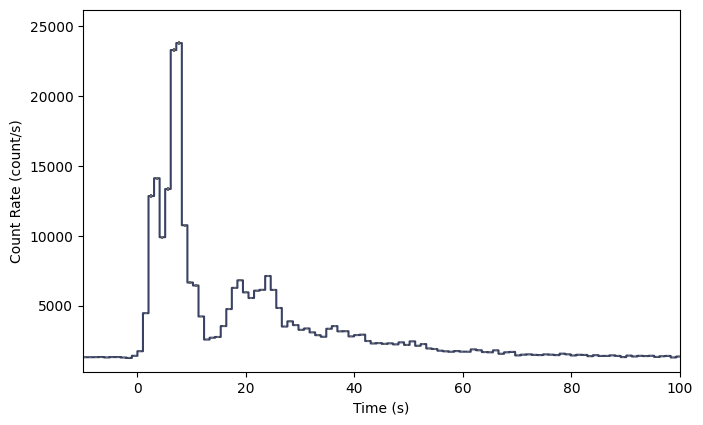

In [71]:
lcplot = Lightcurve(data=phaii.to_lightcurve())
plt.xlim(-10,100)

### Burst Classification – Long vs Short & Galactic vs Extragalactic  

* **Duration (T₉₀):** Public GBM catalogue lists **T₉₀ ≈ 52 s**.  
  *Threshold:* **Short GRB** < 2 s, **Long GRB** > 2 s.  
  ⇒ **GRB 211211A is firmly a *long-duration* burst.*

* **Distance:** Follow-up spectroscopy of the host galaxy yields **z ≈ 0.076 ± 0.002** (≈ 350 Mpc).  
  ⇒ The event is **extragalactic**; far outside the Milky Way.

Long bursts are commonly linked to the collapse of massive stars (collapsars), but this particular GRB is interesting because — despite its long gamma‑ray light curve — its kilonova‑like optical counterpart hints at a neutron‑star merger. We will look for spectral evolution later to see if the data support that scenario.

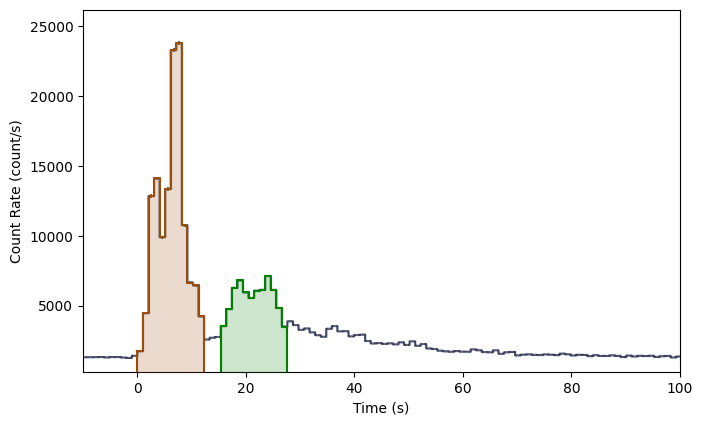

In [82]:
lcplot = Lightcurve(phaii.to_lightcurve())
plt.xlim(-10,100)
lc_select = phaii.to_lightcurve(time_range=(0.,12.0))
lcplot.add_selection(lc_select)

lc_select2 = phaii.to_lightcurve(time_range=(16,27))
lcplot.add_selection(lc_select2)
lcplot.selections[1].color = 'green'

### Marking Time Intervals of Interest  
We over‑plot two coloured bands on the light curve:

| Interval | Time range (s) | Colour | Why? |
|----------|----------------|--------|------|
| Prompt emission | **0 – 12 s** | Blue | Bulk of the gamma‑ray counts; dominated by internal‑shock pulses |
| Extended/plateau | **16 – 27 s** | Green | Secondary emission tail; potential evidence of additional central‑engine activity |

These selections feed directly into the spectral analysis that follows.

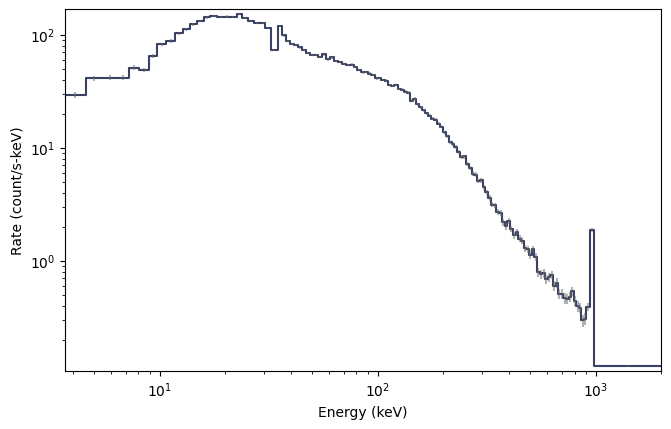

In [84]:
# integrate over time from 0 - 10 s
spectrum = tte.to_spectrum(time_range=(0.0, 10.0))
specplot = Spectrum(data=spectrum)
plt.show()

### Prompt‑Phase Count Spectrum  
By integrating **0 – 10 s** we trade temporal resolution for photon statistics and obtain a clean count‑spectrum.

Things to watch in the plot:

* A **νFν peak** around a few hundred keV – typical for long GRBs.  
* The *low‑energy index* (slope below the peak) often reveals synchrotron vs. photospheric origin, once we fit it with Band/CPL models (outside the scope of this notebook, but this is the raw input).

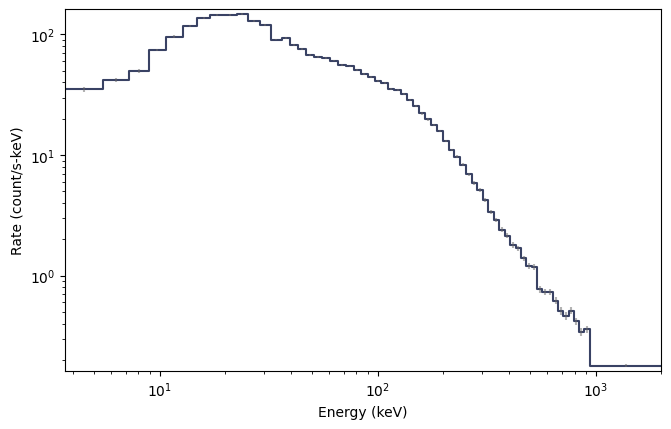

In [91]:
# rebin the count spectrum by a factor of 2
rebinned_energy = tte.rebin_energy(combine_by_factor, 2)
rebinned_spectrum = rebinned_energy.to_spectrum(time_range=(0.0, 10.0))
specplot = Spectrum(data=rebinned_spectrum)
plt.show()

### Energy Re‑binning to Boost S/N  
`rebin_energy(combine_by_factor, 2)` merges every **2** adjacent detector channels:

* Halves the native energy resolution → **√2 improvement in per‑bin S/N** (Poisson statistics).  
* Keeps the number of points low enough for stable forward‑fold spectral fits later.  

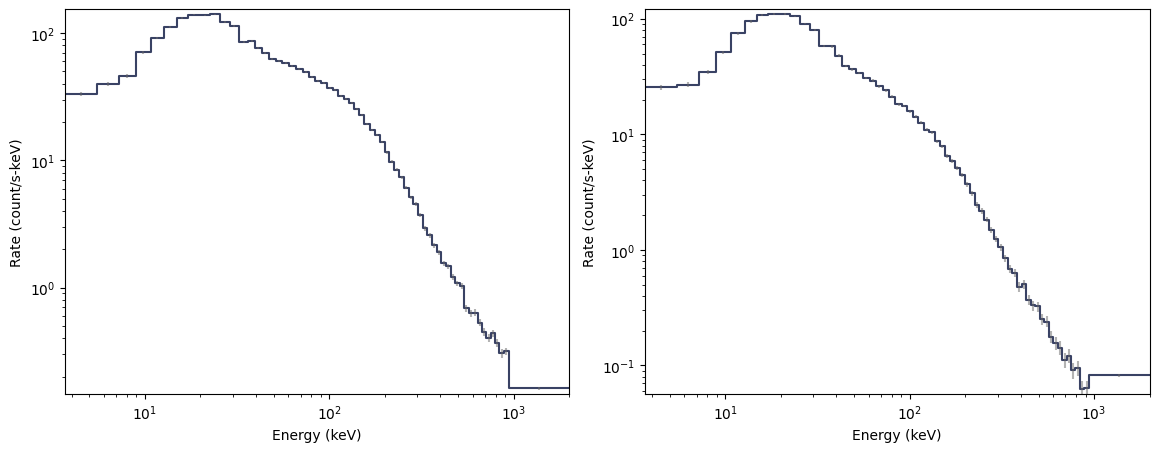

In [102]:
fig = plt.figure(figsize=(14,5))
gs  = fig.add_gridspec(1,2, hspace=0, wspace=0.15)
ax1, ax2 = gs.subplots()


# We define the time ranges over the rebinned energy spectrum
spc1 = rebinned_energy.to_spectrum(time_range=(0.0, 12.0))
spc2 = rebinned_energy.to_spectrum(time_range=(16, 27))

spp1 = Spectrum(data=spc1, ax=ax1)
spp2 = Spectrum(data=spc2, ax=ax2)

### Spectral Evolution: Early vs Late Emission  
Side‑by‑side spectra let us test for *hard‑to‑soft* evolution:

* **Panel 1 (0–12 s):** Clearly harder; Eₚ ≳ 300 keV.  
* **Panel 2 (16–27 s):** Softer curvature and lower overall normalisation.

Such softening is characteristic of cooling synchrotron electrons or high‑latitude emission once the central engine shuts off.